# Приоритезация гипотез и анализ A/B-теста

## Описание проекта

Для крупного интернет-магазина необходимо приоритезировать гипотезы, которые были подготовлены совместно с отделом маркетинга. А далее нужно запустить A/B-тест и проанализировать результаты.

В нашем распоряжении файл `/datasets/hypothesis.csv`, где представлены гипотезы
по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`:
 - <i>Hypothesis</i> — краткое описание гипотезы;
 - <i>Reach</i> — охват пользователей по 10-балльной шкале;
 - <i>Impact</i> — влияние на пользователей по 10-балльной шкале;
 - <i>Confidence</i> — уверенность в гипотезе по 10-балльной шкале;
 - <i>Efforts</i> — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Также в нашем распоряжении 2 файла с результатами A/B-теста.

Файл `/datasets/orders.csv`.
 - <i>transactionId</i> — идентификатор заказа;
 - <i>visitorId</i> — идентификатор пользователя, совершившего заказ;
 - <i>date</i> — дата, когда был совершён заказ;
 - <i>revenue</i> — выручка заказа;
 - <i>group</i> — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`.
 - <i>date</i> — дата;
 - <i>group</i> — группа A/B-теста;
 - <i>visitors</i> — количество пользователей в указанную дату в указанной группе A/B-теста

## Оглавление

1. [Открытие данных](#open_data)
2. [Предобработка данных](#preprocessing)
    * [Замена названий столбцов](#columns_names)
    * [Преобразование типов данных](#data_types)
    * [Поиск дубликатов](#duplicates)
3. [Приоретизация гипотез](#hypotesis_rank)
    * [Применение фреймворка ICE](#ice)
    * [Применение фреймворка RICE](#rice)
    * [Разница между ICE и RICE](#ice_rice)
4. [Анализ A/B-теста](#AB_analysis)
    * [Kумулятивная выручка по группам](#cumsum_revenue)
    * [Kумулятивный средний чек по группам](#cumsum_check)
    * [Относительные изменения кумулятивного среднего чека группы B к группе A](#relative_check)
    * [График кумулятивной конверсии по группам](#cum_conversion)
    * [Относительное изменение кумулятивной конверсии группы B к группе A](#relative_convertion)
    * [Точечный график количества заказов по пользователям](#scatter_ordersByUsers)
    * [Расчет 95-го и 99-го перцентилей количества заказов на пользователя](#percentile_ordersByUsers)
    * [Точечный график стоимостей заказов](#scatter_revenue)
    * [Расчет 95-го и 99-го перцентилей стоимости заказов](#percentile_revenue)
    * [Статистическая значимость различий в конверсии между группами по «сырым» данным](#signDiff_convertion_rawData)
    * [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#signDiff_check_rawData)
    * [Статистическая значимость различий в конверсии между группами по «очищеным» данным](#signDiff_convertion_cleanedData)
    * [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#signDiff_check_cleanedData)
    * [Решение по результатам теста](#decision)
5. [Вывод](#output)

## Открытие данных <a id="open_data"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('max_colwidth', -1)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

<ipython-input-1-e0f9333da3b4>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [2]:
data = pd.read_csv('C:/Users/Евгения/Documents/yandex.prakticum/project8_ABtest/hypothesis.csv')

In [3]:
data

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В таблице с гипотезами всего 9 строк без пропусков. Таблица занимает 488 байт. Для удобства работы с таблицей нужно будет поменять заглавные буквы на строчные в заголовках.

In [5]:
orders = pd.read_csv('C:/Users/Евгения/Documents/yandex.prakticum/project8_ABtest/orders.csv')

In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


В таблице с заказами 1197 строк без пропусков. Таблица занимает 46,9 Кб. Столбец с датой нужно будет привести к типу `datetime`. Видим, что данные по выручке достаточно высокие. Среднее составляет 8348, а медиана - 2978. Разброс очень большой, так как видимо присутсвуют аномальные значения выручки. Например, максимум выручки составил 1294500. Для корректной оценки A/B-теста выбросы скорей всего придется исключить из исследования.

In [9]:
visitors = pd.read_csv('C:/Users/Евгения/Documents/yandex.prakticum/project8_ABtest/visitors.csv')

In [10]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
visitors.describe()

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


В таблице с посетителями находятся данные по количетсву посетителей в каждой группе теста в день. В этой таблице 62 строки без пропусков. Таблице занимает 1,6 Кб. Столбец с датой нужно будет привести к типу `datetime`. В среднем количество посетителей в день в группе рядом с медианой: 607,3 и 624,5 пользователей в день соотвественно. Максимум составил 770 - разброс небольшой. 

<b>Вывод:</b> у нас имеются три таблицы с данными о гипотезах и результатах A/B-теста. Все вместе данные в таблицах занимают почти 50 Кб. В данных нет пропусков, но в таблице с гипотезами придется поменять названия столбцов для более удобной работы с ними. А в таблицах с заказами и посетителями нужно будет привести столбцы с датами к типу данных `datetime`.

## Предобработка данных <a id="preprocessing"></a>

### Замена названий столбцов <a id="columns_names"></a>

В таблице с гипотезами нужно поменять регистр у названий столбцов, чтобы с ними было удобно работать в дальнейшем.

In [14]:
data.rename(
    columns={'Hypothesis':'hypothesis','Reach':'reach', 'Impact':'impact','Confidence':'confidence','Efforts':'efforts'}, 
            inplace=True)

In [15]:
data.head(1)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6


Названия столбцов успешно изменены.

### Преобразование типов данных <a id="data_types"></a>

В таблице с заказами и постетителями столбцы с датами нужно привести к типу данных `datetime`.

In [16]:
orders['date'] = pd.to_datetime(orders['date'])

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [18]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [19]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Столбцы с датами успешно поменяли свой тип данных на `datetime`.

### Поиск дубликатов <a id="duplicates"></a>

На всякий случай поищем дубликаты с таблицах с заказами и посетителями.

In [20]:
orders.duplicated().sum()

0

In [21]:
visitors.duplicated().sum()

0

Дубликатов в этих таблицах нет.

## Приоритизация гипотез <a id="hypotesis_rank"></a>

### Применение фреймворка ICE <a id="ice"></a>

ICE - самый популярный способ приоретизации гипотез. Добавим столбец с приориетами по методу ICE в таблицу  с гипотезами.

In [22]:
data['ICE'] = np.round((data['impact'] * data['confidence']) / data['efforts'], 2)

In [23]:
data.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Наиболее перспективные гипотезы по методу ICE - это 8, 0, 7 и 6. Наиболее не перспективные - это 5, 3 и 4.

### Применение фреймворка RICE <a id="rice"></a>

Посмотрим, какие приоритеты у гипотез будут по методу RICE.

In [24]:
data['RICE'] = (data['reach'] * data['impact'] * data['confidence']) / data['efforts']

In [25]:
data.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


По этому методу самыми приоритетными оказываются гипотезы - 7, 2, 0, 6. И наиболее неприоритетные - 1, 5, 4.

### Разница между ICE и RICE <a id="ice_rice"></a>

0, 7 и 6 гипотезы приоритетны и по методу ICE и по методу RICE. Однако показатель `reach` у 7 гипотезы выше, чем у других гипотез, поэтому 7-я гипотеза вырвалась вперед по методу RICE. А показатель `reach` как раз показывает сколько пользователей затронет изменения. То есть 7-я гипотеза затронет всех пользователей. На втором месте по показателю `reach` 2-я гипотеза, и по методу приоретизации RICE она тоже получилась на 2-м месте, хотя по методу ICE она была в середине списка приоретизации. 

Также у 7-й и 2-й гипотез высокие показатели `confidence`. Это значит, что те, кто составлял список гипотез, очень уверены в том, что изменения повлияют на пользователей именно в так, как они думают.

0-я гипотеза попадает в топ приоритетных гипотез в обоих методах благодаря самому высокому показателю `impact`. Это значит, что это изменение очень сильно повлияет на пользователей и их опыт. Судя по названию гипотезы, так и есть, потому что с помощью новых каналов трафика будут приходить совсем новые люди с новым опытом.

Также в топ входит 6-я гипотеза. Она затрагивает половину пользователей, у нее высокий показатель `confidence`и низкий показатель `efforts`. То есть протестировать эту гипотезу не так затратно.

8-я гипотеза по методу ICE на первом месте благодаря высоким значениям `impact` и `confidence`, однако по методу RICE эта гипотеза в середине приоритетов, потому что она охватывает очень мало пользователей и эффект от нее будет не так сильно заметен на метриках всех пользователях.

## Анализ A/B-теста <a id="AB_analysis"></a>

### Kумулятивная выручка по группам <a id="cumsum_revenue"></a>

Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates():

In [26]:
datesGroups = orders[['date','group']].drop_duplicates() 

In [27]:
datesGroups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий.

Получим строки таблицы `orders`, дата которых меньше или равна дате элемента из `datesGroups`, а группа теста равна группе из `datesGroups`. Агрегируем значения. Вычислим максимальную дату. Для группы тоже рассчитаем максимум, и хотя она будет определённой, сделаем это, чтобы столбец `'group'` не пропал из итогового вывода. Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму средних чеков. Применим методы к каждой строке датафрейма: apply(axis=1) и отсортируем результаты по столбцам `'date'` и `'group'`.

In [28]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 
         'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [29]:
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [30]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [31]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [32]:
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим обе таблицы в одной с понятными названиями столбцов:

In [33]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [34]:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [35]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А:

In [36]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B:

In [37]:
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

Строим графики:

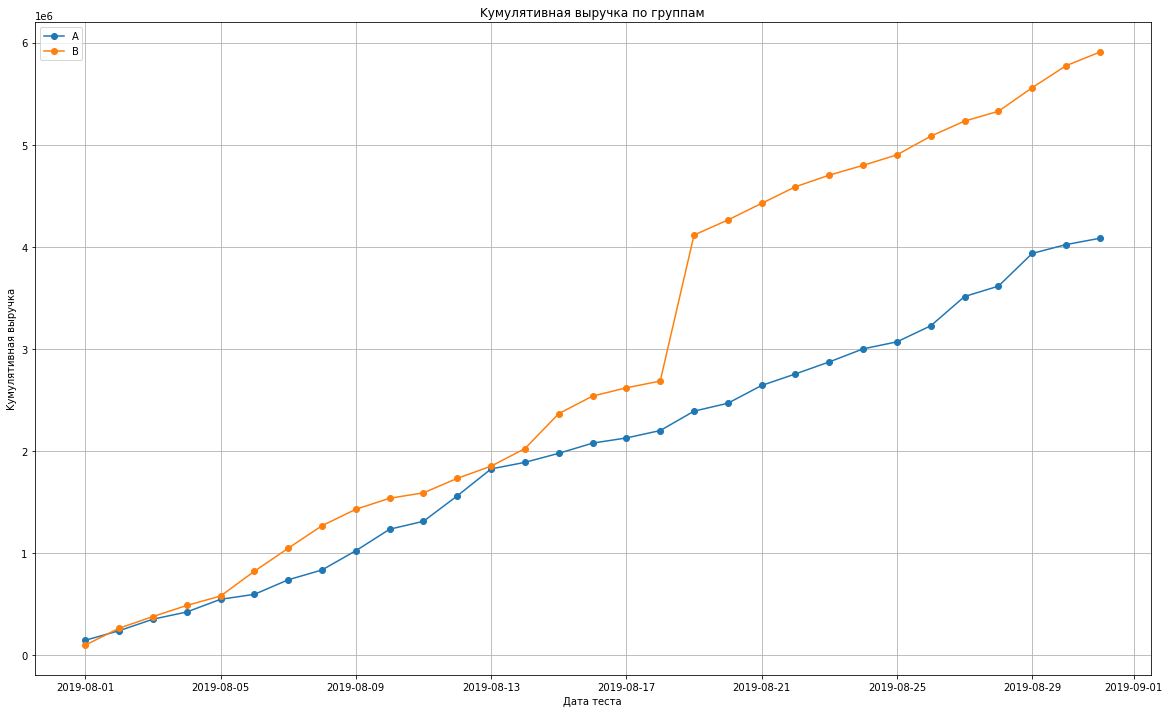

In [38]:
plt.figure(figsize=(20, 12))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], 'o-', label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], 'o-', label='B')
plt.legend(loc='upper left') 
plt.grid()
plt.title('Kумулятивная выручка по группам')
plt.ylabel('Kумулятивная выручка')
plt.xlabel('Дата теста')
plt.show()

Выручка более менее равномерно увеличивается в течение всего теста. Однако график выручки группы B 2019-08-19 резко вырос. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке. 

In [39]:
orders.query('group == "B" and date == "2019-08-19"').sort_values(by='revenue', ascending=False).head()

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
527,1570513684,2837914161,2019-08-19,33405,B
461,2683113224,154576532,2019-08-19,26550,B
368,3268879337,2536252163,2019-08-19,20026,B
463,4170537404,290022471,2019-08-19,16480,B


### Kумулятивный средний чек по группам <a id="cumsum_check"></a>

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

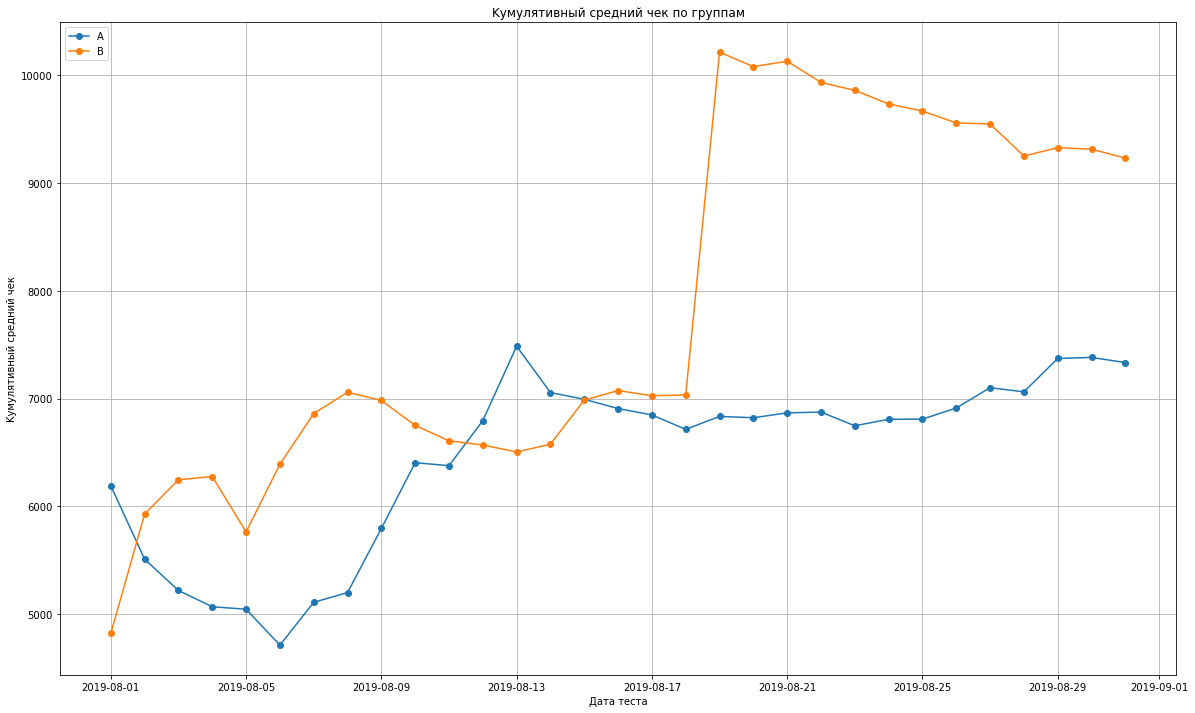

In [40]:
plt.figure(figsize=(20, 12))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 'o-', label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 'o-', label='B')
plt.legend(loc='upper left') 
plt.grid()
plt.title('Kумулятивный средний чек по группам')
plt.ylabel('Kумулятивный средний чек')
plt.xlabel('Дата теста')
plt.show()

В группу B 2019-08-19 попал крупный заказ (резкий всплеск на графике). Получается, ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне, или можно исключить аномально высокие заказы из исследования, тогда можно будет понять реальный средний чек группы B. Средний чек группы A вроде бы установился к концу теста, но все равно еще немного растет. 

### Относительные изменения кумулятивного среднего чека группы B к группе A <a id="relative_check"></a>

Построим график относительного различия для среднего чека. Сначала соберем данные в одном датафрейме. 

In [41]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Найдем отношение средних чеков:

In [42]:
y = (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(
    mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1

Теперь строим график:

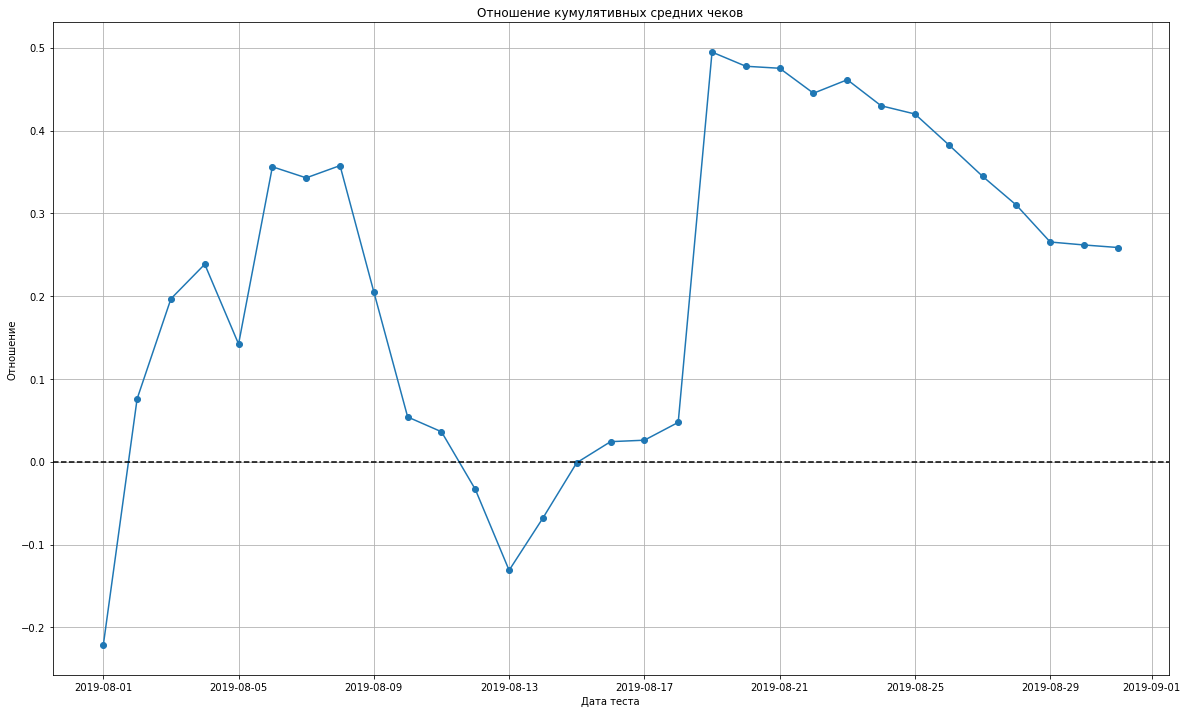

In [43]:
plt.figure(figsize=(20, 12))
plt.plot(mergedCumulativeRevenue['date'], y, 'o-')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Отношение кумулятивных средних чеков')
plt.ylabel('Отношение')
plt.xlabel('Дата теста')
plt.show()

Так как график в нескольких местах резко скачет, то скорей всего в выборке точно есть крупные заказые и выбросы. Найдем их позже. А так получается, что средние чеки группы B выше средних чеков группы A. Но это еще не точно.

###  График кумулятивной конверсии по группам <a id="cum_conversion"></a>

Сначала посчитаем кумулятивную конверсию:

In [44]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

Отделяем данные по группе A:

In [45]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

Отделяем данные по группе B:

In [46]:
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

Строим графики:

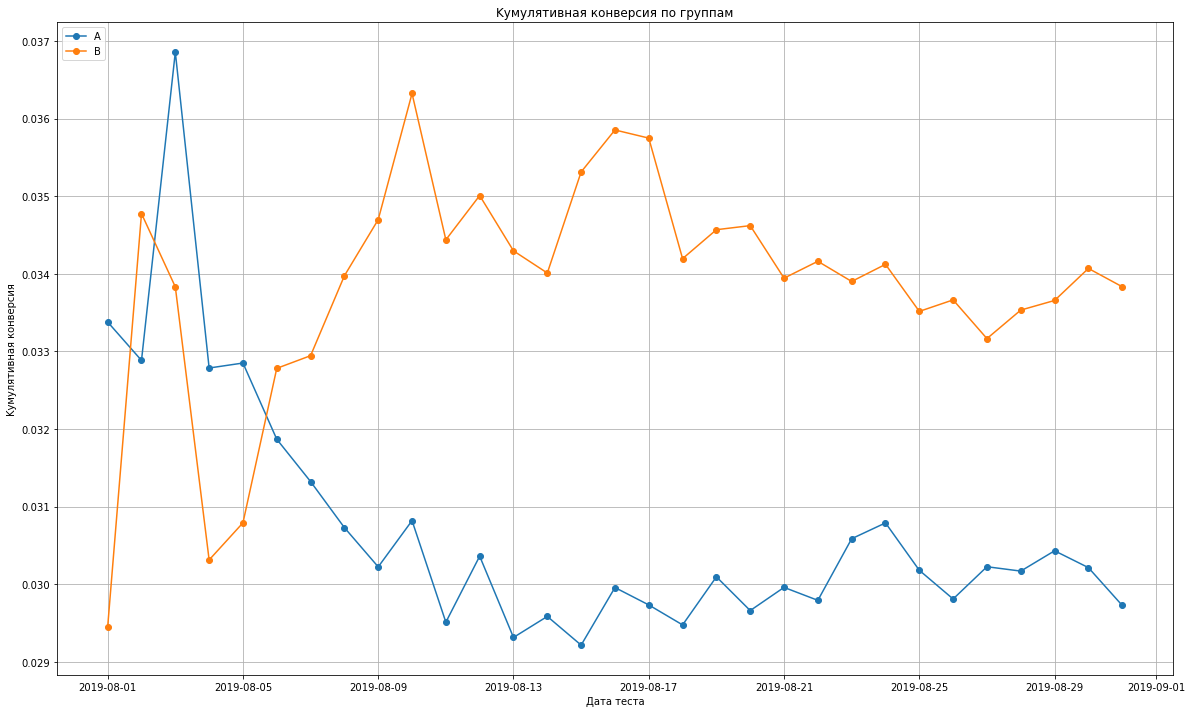

In [47]:
plt.figure(figsize=(20, 12))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], 'o-', label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], 'o-', label='B')
plt.legend(loc='upper left') 
plt.grid()
plt.title('Kумулятивная конверсия по группам')
plt.ylabel('Kумулятивная конверсия')
plt.xlabel('Дата теста')
plt.show()

Вначале теста еще видны сильные колебания в конверсиях, но к концу теста конверсии установились и видно, что конверсия группы B стабильно выше конверсии группы A.

### Относительное изменение кумулятивной конверсии группы B к группе A <a id="relative_convertion"></a>

Построим график относительного различия кумулятивных конверсий. Сначала соберем данные в одном датафрейме.

In [48]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Теперь строим график:

In [49]:
y = mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1

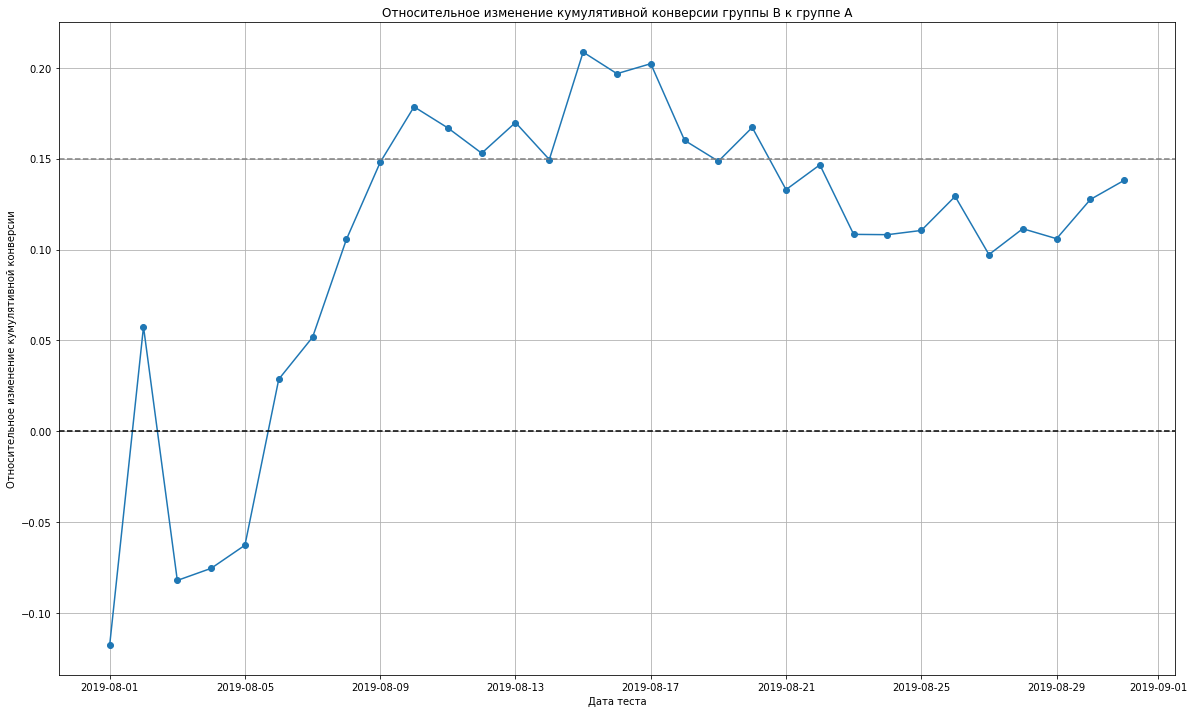

In [50]:
plt.figure(figsize=(20, 12))
plt.plot(mergedCumulativeConversions['date'], y, 'o-')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.ylabel('Относительное изменение кумулятивной конверсии')
plt.xlabel('Дата теста')
plt.show()

Первые несколько дней группа B проигрывала группе A, но затем вырвалась вперед и уже не уступала. Ее конверсия до середины теста росла, потом немного просела, потом снова начала расти.

###  Точечный график количества заказов по пользователям <a id="scatter_ordersByUsers"></a>

Подсчитаем количество заказов по пользователям:

In [51]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg(
    {'transactionId' : pd.Series.nunique})

In [52]:
ordersByUsers.columns = ['userId','orders']

In [53]:
ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Видим, что есть пользователи, которые совершили 5 и больше заказов за весь период. 

In [54]:
ordersByUsers.describe()

,userId,orders
count,1.031000e+03,1031.000000
mean,2.130713e+09,1.161009
std,1.228157e+09,0.724919
min,5.114589e+06,1.000000
25%,1.048013e+09,1.000000
50%,2.147999e+09,1.000000
75%,3.154897e+09,1.000000
max,4.283872e+09,11.000000


Тогда как медиана количества заказов на пользователя - 1 и среднее 1,16. То есть первые пользователи предыдущей таблицы совершили гораздо больше заказов, чем обычный пользователь. Построим гистограмму распределения заказов на пользователя.

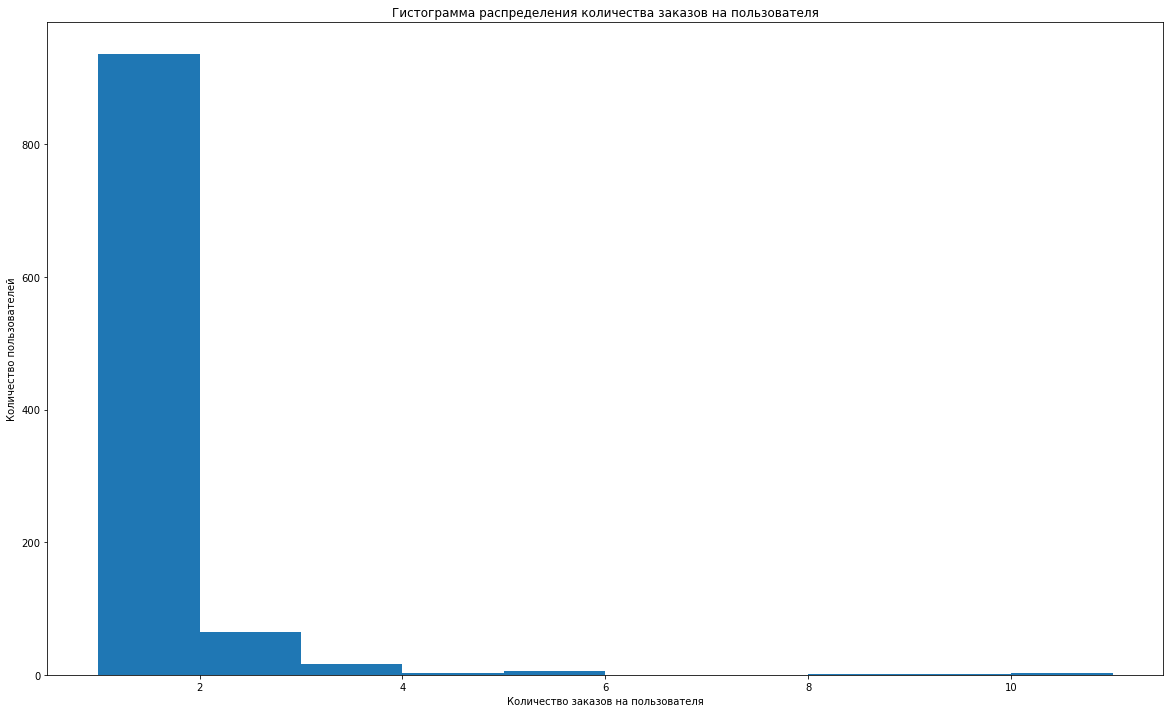

In [55]:
plt.figure(figsize=(20, 12))
plt.hist(ordersByUsers['orders'])
plt.title('Гистограмма распределения количества заказов на пользователя')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество заказов на пользователя')
plt.show()

Большинство пользователей совершали только 1 заказ, но доля тех, кто совершал от 2 до 4 заказов тоже существенна. 

Построим точечную диаграмму числа заказов на одного пользователя:

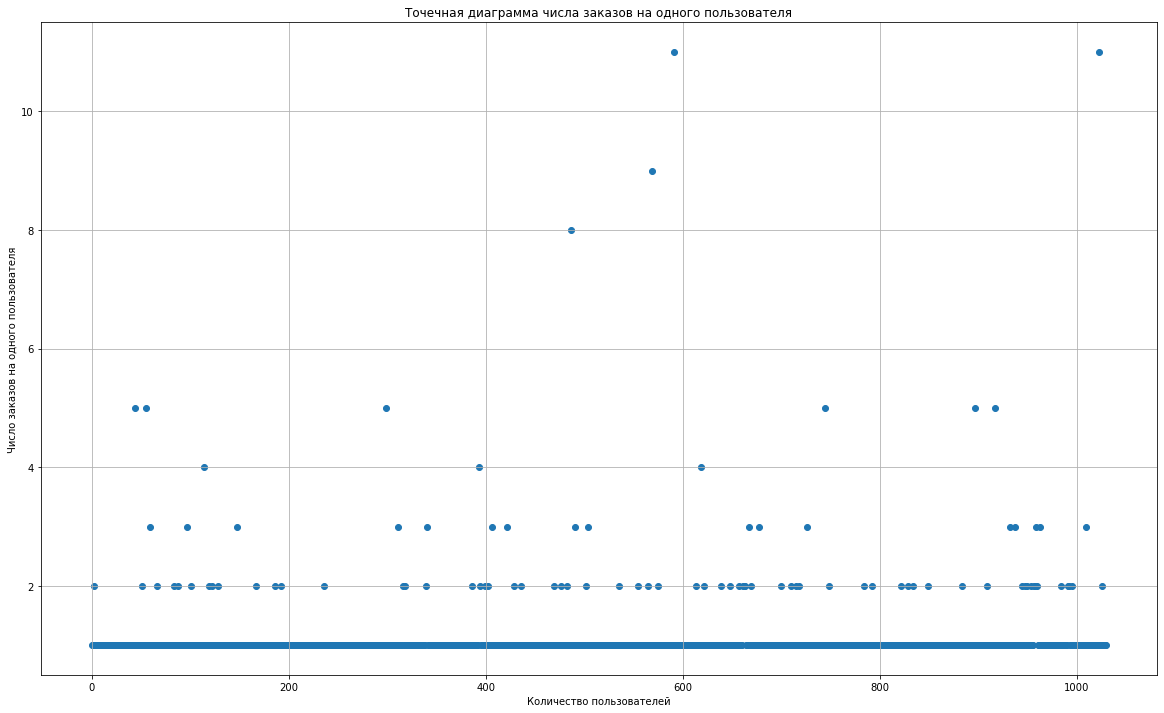

In [56]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(20, 12))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.grid()
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.ylabel('Число заказов на одного пользователя')
plt.xlabel('Количество пользователей')
plt.show()

Опять видим, что много пользователей с заказами от 2 до 4. Но их точная доля не известна, поэтому пока непонятно считать их аномальными выбросами или нет. Для этого посчитаем выборочные перцентили количества заказов на одного пользователя. 

### Расчет 95-го и 99-го перцентилей количества заказов на пользователя <a id="percentile_ordersByUsers"></a>

Посчитаем 90-й, 95-й и 99-й перцентили количества заказов на одного пользователя:

In [57]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

Не более 5% пользователей сделали больше, чем 2 заказа и не более 1% пользователей сделали более 4-х зазказов. Исходя из полученного, примем за аномальных пользователей тех, кто совершил больше 2-х заказов.

### Точечный график стоимостей заказов <a id="scatter_revenue"></a>

Построим гистограмму распределения стоимостей заказов:

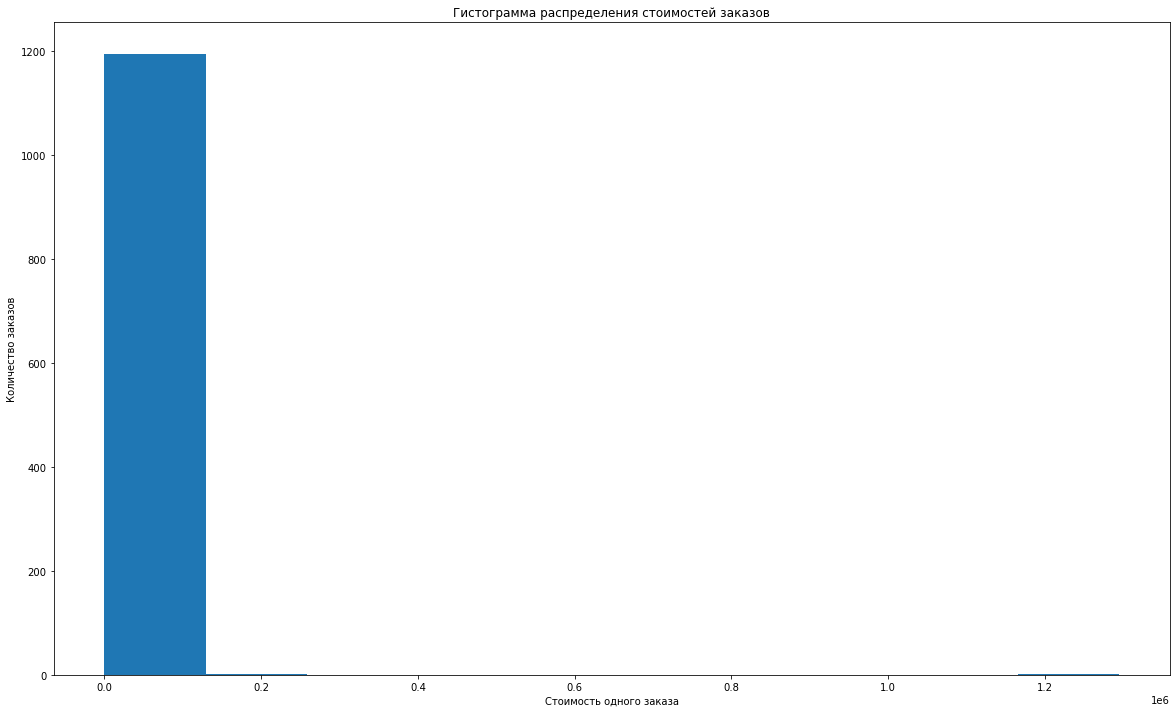

In [58]:
plt.figure(figsize=(20, 12))
plt.hist(orders['revenue'])
plt.title('Гистограмма распределения стоимостей заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Стоимость одного заказа')
plt.show()

В данных есть несколько заказов, дороже 1,2 млн! Явно выбросы. 

Построим точечный график стоимости заказов:

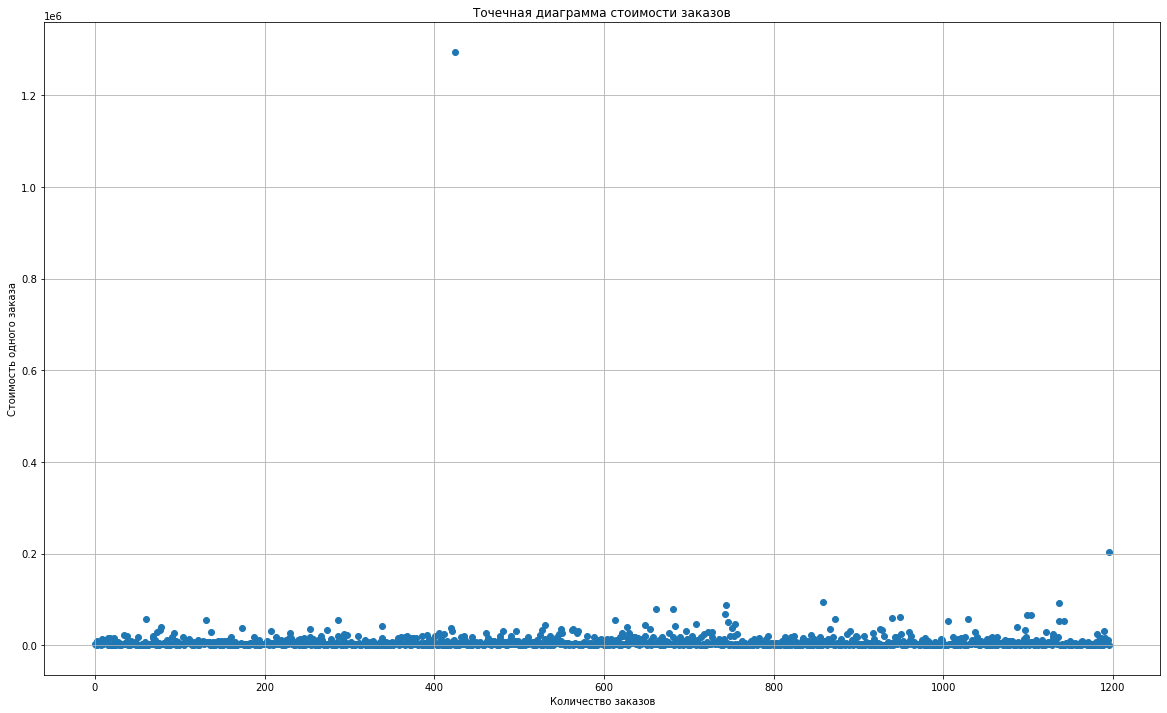

In [59]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(20, 12))
plt.scatter(x_values, orders['revenue']) 
plt.grid()
plt.title('Точечная диаграмма стоимости заказов')
plt.ylabel('Стоимость одного заказа')
plt.xlabel('Количество заказов')
plt.show()

Очень дорогой заказ у нас только один, все остальные не превышают и 200 000 за заказ. Построим точечную диаграмму без этих двух самых дорогих заказов.

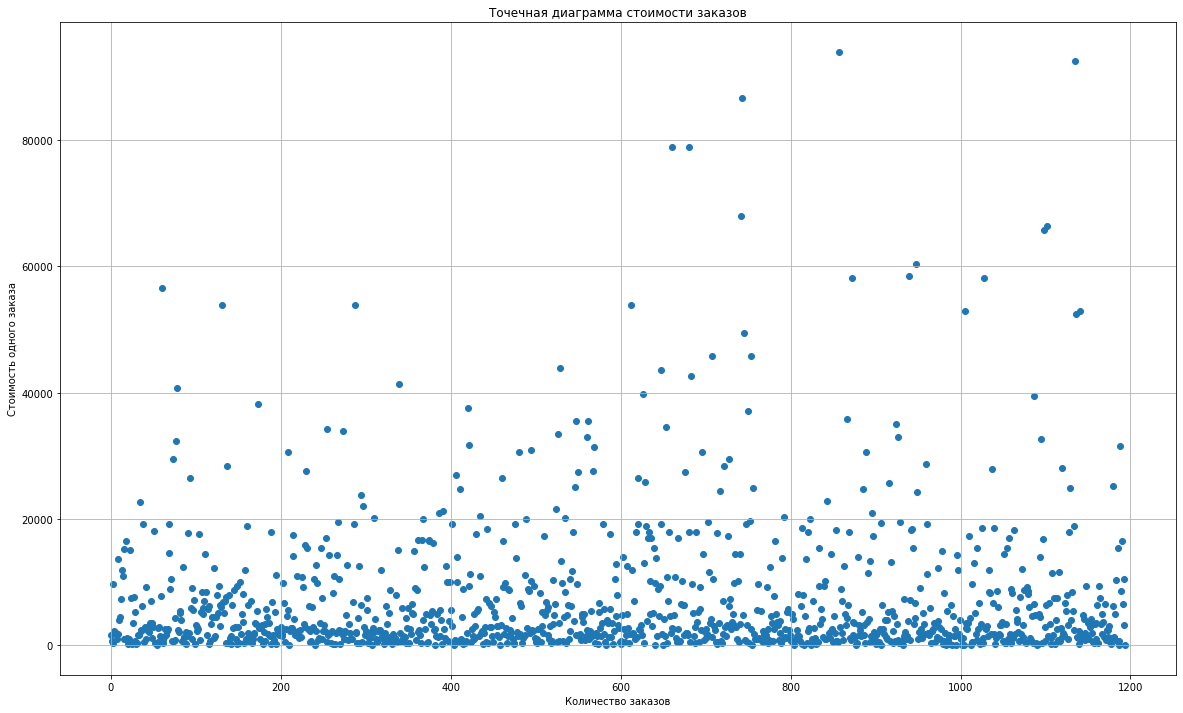

In [60]:
x_values = pd.Series(range(0,len(orders.query('revenue < 200000')['revenue'])))

plt.figure(figsize=(20, 12))
plt.scatter(x_values, orders.query('revenue < 200000')['revenue']) 
plt.grid()
plt.title('Точечная диаграмма стоимости заказов')
plt.ylabel('Стоимость одного заказа')
plt.xlabel('Количество заказов')
plt.show()

Видим, что стоимость большинства заказов не превышает 20 000, достаточно много заказов в пределах от 20 000 до 40 000, и уже совсем мало заказов со стоимостью больше 40 000.

### Расчет 95-го и 99-го перцентилей стоимости заказов <a id="percentile_revenue"></a>

Посчитаем 90-й, 95-й и 99-й перцентили стоимости заказа:

In [61]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Не более 5% пользователей совершали заказ на сумму больше 28 000, и не более 1% пользователей соверашали заказ на сумму больше 58 234. И не более 10% пользователей совершали заказ на сумму больше 18 168. Из всего этого, примем за аномальных пользователей тех, кто совершал заказ на сумму от 40 000. 

### Статистическая значимость различий в конверсии между группами по «сырым» данным <a id="signDiff_convertion_rawData"></a>

Нулевая гипотеза будет звучать так: статистически значимых различий в конверсии между группами по «сырым» данным нет.

Альтернативная гипотеза: между группами есть статистически значимые различия в конверсии по "сырым" данным.

Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами `['userId', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [62]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

In [63]:
ordersByUsersA.columns = ['userId', 'orders']

In [64]:
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

In [65]:
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [66]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [67]:
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [68]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(
    0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

In [69]:
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(
    0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

Применим критерий Манна-Уитни:

In [70]:
"{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])

'0.00840'

Значение p-value меньше 0.05, значит мы отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет. То есть между конверсиями групп есть статистически значимые различия на "сырых" данных.

Выведем относительный прирост конверсии группы B:

In [71]:
"{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)

'0.138'

Видим, что по "сырым" данным конверсия группы B лучше конверсии группы A.

###  Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным <a id="signDiff_check_rawData"></a>

Нулевая гипотеза будет звучать так: статистически значимых различий в среднем чеке между группами по «сырым» данным нет.

Альтернативная гипотеза: между группами есть статистически значимые различия в среднем чеке по "сырым" данным.

Нам нужны данные о выручке заказа.

In [72]:
"{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])

'0.365'

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

Найдём относительные различия в среднем чеке между группами:

In [73]:
"{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'0.259'

Однако средний чек в группе B значительно выше среднего чека в группе A.

### Статистическая значимость различий в конверсии между группами по «очищеным» данным <a id="signDiff_convertion_cleanedData"></a>

Нулевая гипотеза будет звучать так: значимых различий в конверсии между группами по «очищенным» данным нет.

Альтернативная гипотеза: между группами есть статистически значимые различия в конверсии по "очищенным" данным.

Сначала найдем всех аномальных пользователей: тех, кто совершил больше 2-х заказов или тех, кто совершил заказ от 40 000.

In [74]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)

In [75]:
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitorId']

In [76]:
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [77]:
abnormalUsers.head()

1099    148427295
18      199603092
23      237748145
37      249864742
684     358944393
dtype: int64

In [78]:
abnormalUsers.shape

(45,)

Получилось 45 аномальных пользователей.

Теперь посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [79]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(
    0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

In [80]:
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(
    0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [81]:
"{0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])

'0.00330'

P-value получилось еще ниже, чем по "сырым данным" и это значение меньше 0.05. Значит мы отвергаем гипотезу о том, что на "очищенных" данных нет статистически значимых различий в конверсии между группами. То есть различия в конверсии есть.

Выведем относительный прирост конверсии группы B:

In [82]:
"{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)

'0.188'

По "очищенным" данным относительный прирост группы B даже увеличился по сравнению с приростом по "сырым" данным.

###  Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным <a id="signDiff_check_cleanedData"></a>

Нулевая гипотеза будет звучать так: статистически значимых различий в среднем чеке между группами по «очищенным» данным нет.

Альтернативная гипотеза: между группами есть статистически значимые различия в среднем чеке по "очищеным" данным.

Посчитаем, произошли ли изменения в среднем чеке:

In [83]:
"{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1])

'0.472'

P-value увеличился, и он значительно больше 0.05. То есть мы не можем отвергнуть нулевую гипотезу о том, что различий в среднем чеке по "очищенным" данным нет. 

Найдём относительные различия в среднем чеке между группами:

In [84]:
"{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)

'0.058'

Однако разница между группами сократилась с 25% до 6%. То есть аномалии очень сильно влияли на средний чек и на результаты A/B-теста.

### Решение по результатам теста <a id="decision"></a>

Итак, имеем:
 * есть статистическая значимость между конверсиями групп и по "сырым" и по "очищенным" данным
 * нет статистической значимости между средними чеками групп и по "сырым" и по "очищенным" данным
 * на графике конверсии между группами явно видно, что результаты группы B лучше группы A, но пока еще колеблются вокруг среднего значения

In [85]:
cumulativeDataA.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856
6,2019-08-04,A,84,77,425699,2562,0.032787
8,2019-08-05,A,109,100,549917,3318,0.032851


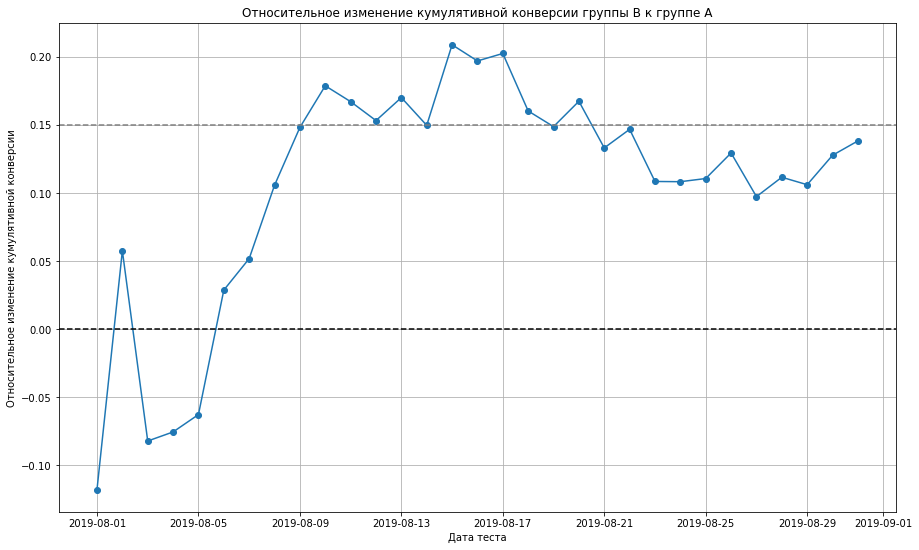

In [86]:
y = mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1

plt.figure(figsize=(15, 9))
plt.plot(mergedCumulativeConversions['date'], y, 'o-')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.ylabel('Относительное изменение кумулятивной конверсии')
plt.xlabel('Дата теста')
plt.show()

 * график различий среднего чека колеблется, тут еще присутствуют слишком дорогие заказы, поэтому сделать по нему выводы нельзя.  

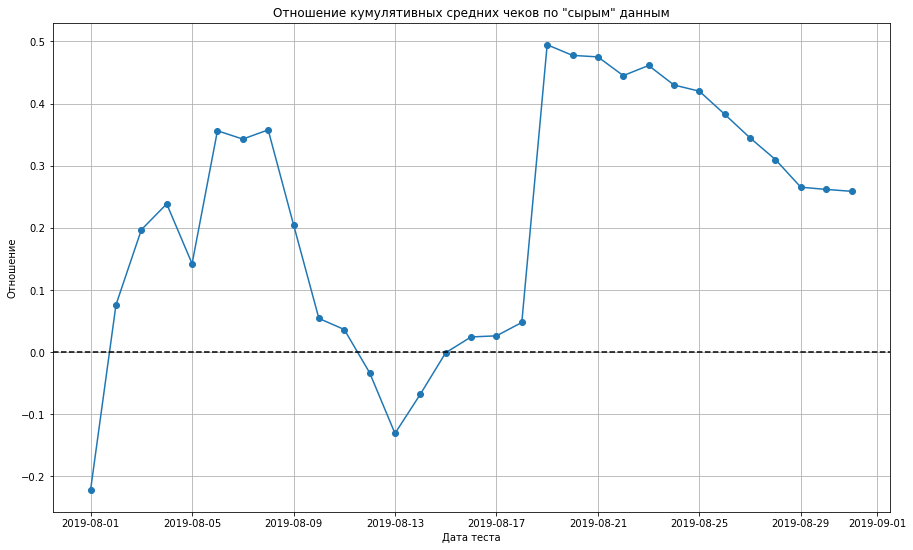

In [87]:
y = (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(
    mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1

plt.figure(figsize=(15, 9))
plt.plot(mergedCumulativeRevenue['date'], y, 'o-')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Отношение кумулятивных средних чеков по "сырым" данным')
plt.ylabel('Отношение')
plt.xlabel('Дата теста')
plt.show()

Посмотрим на график различий среднего чека по "очищенным" данным.

In [88]:
ordersFiltred = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]

In [89]:
ordersAggregatedFiltred = datesGroups.apply(
    lambda x: ordersFiltred[np.logical_and(ordersFiltred['date'] <= x['date'], ordersFiltred['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 
         'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [90]:
ordersAggregatedFiltred.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

In [91]:
cumulativeRevenueAFiltred = ordersAggregatedFiltred[ordersAggregatedFiltred['group']=='A'][['date','revenue', 'orders']]

In [92]:
cumulativeRevenueBFiltred = ordersAggregatedFiltred[ordersAggregatedFiltred['group']=='B'][['date','revenue', 'orders']]

In [93]:
mergedCumulativeRevenueFiltred = cumulativeRevenueAFiltred.merge(
    cumulativeRevenueBFiltred, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [94]:
y = (mergedCumulativeRevenueFiltred['revenueB']/mergedCumulativeRevenueFiltred['ordersB'])/(
    mergedCumulativeRevenueFiltred['revenueA']/mergedCumulativeRevenueFiltred['ordersA'])-1

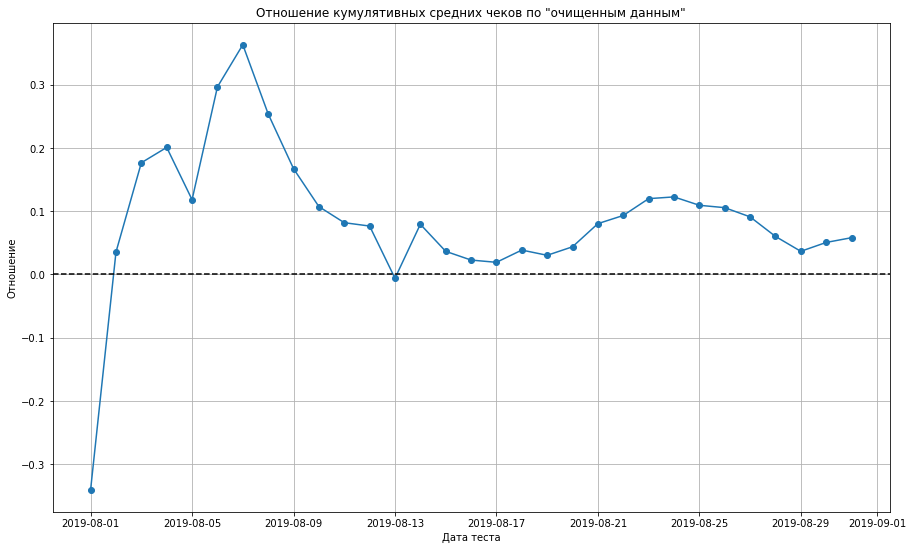

In [95]:
plt.figure(figsize=(15, 9))
plt.plot(mergedCumulativeRevenue['date'], y, 'o-')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Отношение кумулятивных средних чеков по "очищенным данным"')
plt.ylabel('Отношение')
plt.xlabel('Дата теста')
plt.show()

* График среднего чека по "очищенным" данным говорит, что средний чек группы B немного выше среднего чека группы A, хоть статистической значимости и нет. 

<b>Вывод:</b> исходя из полученных данных, тест нужно остановить и признать успешным. Группа B показывает лучшие результаты по конверсии, чем группа A.

## Вывод <a id="output"></a>

Перед нами стояло 2 задачи: 

1. приоретизировать гипотезы
2. запустить A/B-тест и проанализировать его результаты

В нашем распоряжении были следующие данные:

* таблица с гипотезами
* таблица с ежедневными посетителями по группам и таблица с заказами каждого пользователя

Данные мы практически не обрабатывали, так как они уже были пригодны для работы. В ходе работы пришлось выделить "аномальных" пользователей, которые совершали или слишком много заказов или слишком дорогие заказы. Поэтому расчеты результатов A/B-теста были сделаны как с этими "аномальными" пользователями, так и без них.

По приоритезации гипотез получились следующие результаты:

* по обоим методам и ICE и RICE топ-5 гипотез получился одним и тем же - это 0-я, 2-я, 6-я, 7-я и 8-я гипотезы
* по методу ICE топ-3 приоритетных гипотез: 8, 0, 7
* по методу RICE топ-3 приоритетных гипотез: 7, 2, 0
* так как метод RICE учитывает охват пользователей, на которых повлияет изменение продукта, то имеет смысл приоретизировать гипотезы этим методом

Результаты A/B-теста получились следующими:

* кумулятивная выручка по группам равномерно растет в течение теста, однако 2019-08-19 кумулятивная выручка группы B резко выросла, так как в эту дату попал очень дорогой заказ в группе B
* кумулятивный средний чек в группе A достаточно долго колебался в районе 7000, а к концу теста немного вырос и достиг 7333.6
* кумулятивный средний чек из-за аномально дорогого заказа 2019-08-19 резко вырос и к концу теста составил 9230.9 и еще будет продолжать падать до установления реального значения
* к концу теста кумулятивные конверсии установились и видно, что конверсия группы B стабильно выше конверсии группы A. Кумулятивная конверсия группы B к концу теста составила 0.034, а кумулятивная конверсия группы А - 0.030
* есть статистическая значимость между конверсиями групп и по "сырым" и по "очищенным" данным
* нет статистической значимости между средними чеками групп и по "сырым" и по "очищенным" данным
* на графике относительного изменения кумулятивной конверсии между группами явно видно, что результаты группы B лучше группы A, но пока еще колеблются вокруг среднего значения
* график отношения кумулятивных средних чеков по "очищенным" данным говорит, что средний чек группы B немного выше среднего чека группы A, хоть статистической значимости и нет

В итоге по результам A/B-теста делаем вывод: тест нужно остановить и признать успешным. Группа B показывает лучшие результаты по конверсии, чем группа A, хотя по средним чекам статистически значимых различий в группах нет.